# Introduction to synthetic experimentation

This notebook introduces the concept of synthetic experiments and demonstrates how to implement one using Python. 

Synthetic experiments are a powerful tool for studying the relationship between independent variables (factors) and dependent variables (observations) in an controlled environment. They allow us to generate data that resembles real-world data but is not as complex as data collected in the real world while being also free from the limitations, costs and biases that can arise from collecting data in the real world. 

This way, the later introduced concepts and algorithms from the 'Optimizing Experimental Design' course can be implemented, tested and validated easily. 

In this tutorial, you will learn how to:

- Define a ground truth function that represents the true relationship between the independent and dependent variables.
- Generate noisy data by adding noise to the true function values.
- Define treatments and experimental units which will serve as the base for collecting data
- Generating a dataset by defining a sample size, different treatments and eventually collecting samples.
- Run a model recovery to fit a model to the collected data and recover the parameters of the ground truth function.
- Get a feeling for the recovered model quality in dependence of the sample size and noise level

You will also explore how to experiment with different noise levels, sample sizes, and conditions to see how they affect the results of the model recovery.

By the end of this tutorial, you will have a strong understanding of how to implement and analyze synthetic experiments using Python.

# Experiment description

We want to examine the response times of participants in a two-alternative-forced-choice (2AFC) experiment. This experiment consists of an image which is shown for a short period of time. The image is a grid of either orange or blue tiles as shown in the picture below. 

We can control the experiment via the two factors **ratio** and **scatterdness**. 
**Ratio** determines the amount of blue vs orange tiles, where 0 means that the participant sees only orange tiles while 1 means that the amount of blue vs orange tiles is perfectly balanced. 
**Scatterdeness** determines how noisy the image appears, where 0 means that all orange tiles are placed on the left half while 1 means that the tiles are placed completely randomly.

![static/img/2afc_grid.png](static/img/2afc_grid.png)

(Image source: Trueblood J. S. et al (2021)., Urgency, Leakage, and the Relative Nature of Information Processing in
Decision-Making.)

## Import all the relevant libraries and packages

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from typing import Callable, Iterable

np.random.seed(42)

# Add the path of the project folder to the python variables
# That way python finds custom packages defined in the project folder
target_folder = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Adjust path as needed
if target_folder not in sys.path:
    sys.path.append(target_folder)

## Implementing a ground truth

In this section we will implement a ground truth which will serve us later to generate observations and thus let's us perform our experiment.

In this section, you will learn to:
- Implement the ground truth method that models the relationship between the independent variables (factors) and the dependent variable (observation).
- Implement a method that generates noise and add it to the output of the ground truth
- Implement a class, whose instances will resemble the experimental units (e.g. participants)
- Create experimental units given sets of parameters and generate first observations

### Implement a ground truth

The ground truth can be any mathematical expression that takes in the independent variables as arguments and returns the dependent variable.

In our case, we will model a 2-factor ground truth with the two factors 'x' and 'y' and their respective parameters.

Replace the variable 'dependent_variable' which is currently 'None' with the actual value.

In [2]:
def ground_truth(x, y, parameters=np.ones(2,)):
    """This ground truth takes in two factors and a set of parameters and returns a response

    Args:
        x (float): The level of the first factor
        y (float): the level of the second factor
        parameters (Iterable[float], optional): The parameters give an individual configuration for each experimental unit. Defaults to np.ones(2,).

    Returns:
        float: Dependent variable which serves as the response
    """
    
    # this is an example of a ground truth function with two linear terms and a constant term 
    # dependent_variable = parameters[0] * x + parameters[1] * y + parameters[0] + parameters[1]
    
    # this is an example of a bell-shaped function which can saturate
    dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])
    
    return dependent_variable

Test your ground truth by giving it random values and check if it has the desired properties.

Replace now the None-values with your own factor levels and parameters.

This code takes in the specified levels for the factors (conditions) ratio and scatteredness, and the experimental unit (participant) parameters. The output are reponse time observation which we can visualize in a 3D-plot over the given factor levels.

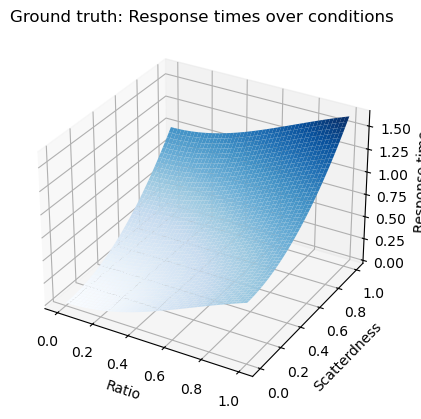

In [62]:
# define the factor levels
# you can use numpy arrays, lists or tuples
x = np.linspace(0, 1)
y = np.linspace(0, 1)
parameters = [1, 2]

# DO NOT TOUCH THE CODE FROM HERE!

# set a sample size
sample_size = len(x)

# initiate the z array
z = np.zeros((sample_size, sample_size))

# collect the observations
x, y = np.meshgrid(x, y)
for i in range(sample_size):
    z[i, :] = ground_truth(x[i], y[i], parameters)

# make a surface plot to visualize the ground_truth
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x, y, z, cmap=cm.Blues)
ax.set_title('Ground truth: Response times over conditions')
ax.set_xlabel('Ratio')
ax.set_ylabel('Scatterdness')
ax.set_zlabel('Response time')
plt.show()

Does it look good? 

Try some parameter configurations to get a feeling for how the response times can change from participant to participant. 

Afterwards you can move to the next part!

## Implementing a noise signal

The noise signal is a value drawn from a normal distribution. 

It will be multiplied by a specified noise level and later be added to the dependent variable to get the final observation.

The scale of normal distribution should be $0.1$

This way we get the inherent noise, which basically any experiment comes with.

Tip: numpy comes already with a method that draws values from a random distribution. Use that one! Call it with np.random.normal(mean, scale)

In [63]:
def noise(noise_level):

    # add your code here:
    
    # draw a value from a normal distribution with the noise level defining the variance
    noise = np.random.normal(0, noise_level)
    
    return noise

Let's check if the noise looks as we expect it to be:

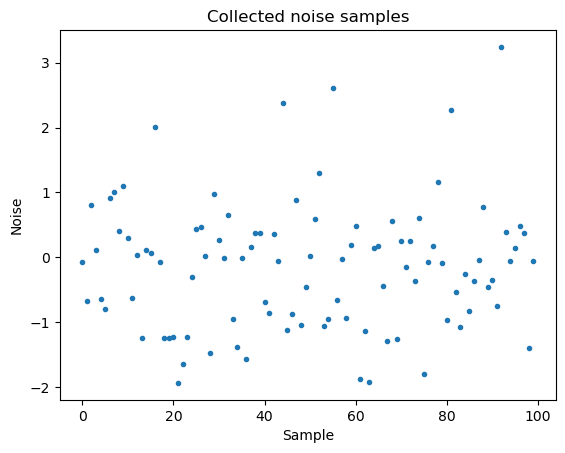

In [64]:
noise_level = 1

noise_sample_size = 100
noise_samples = np.zeros(noise_sample_size)

for i in range(noise_sample_size):
    noise_samples[i] = noise(noise_level=1)
    
plt.plot(noise_samples, '.')
plt.title('Collected noise samples')
plt.ylabel('Noise')
plt.xlabel('Sample')
plt.show()

Now let's add some noise to the observations and compare the previous observations without noise with the current noisy ones

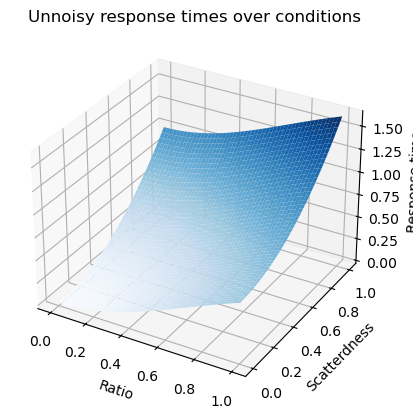

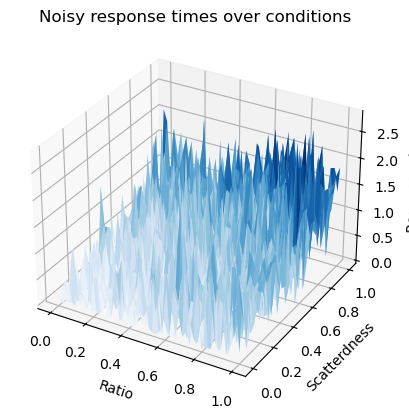

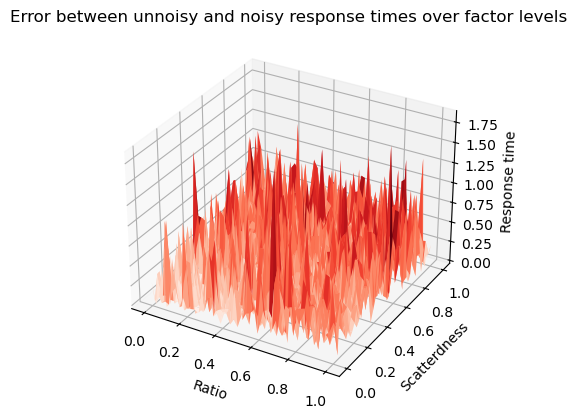

In [65]:
# set noise level
noise_level = 0.5

# initiate the noisy z array
z_noisy = np.zeros((sample_size, sample_size))

# collect the observations
for i in range(sample_size):
    z_noisy[i, :] = ground_truth(x[i], y[i], parameters)
    
# add noise
for i in range(z_noisy.shape[0]):
    for j in range(z_noisy.shape[1]):
        z_noisy[i, j] += noise(noise_level)

# make sure that each sample is bigger than 0 -> no negative response times
z_noisy = np.max(np.stack((np.zeros_like(z_noisy), z_noisy), axis=1), axis=1)

# make a surface plot to visualize the ground_truth
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x, y, z, cmap=cm.Blues)
ax.set_title('Unnoisy response times over conditions')
ax.set_xlabel('Ratio')
ax.set_ylabel('Scatterdness')
ax.set_zlabel('Response time')
plt.show()
# make a surface plot to visualize the ground_truth
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x, y, z_noisy, cmap=cm.Blues)
ax.set_title('Noisy response times over conditions')
ax.set_xlabel('Ratio')
ax.set_ylabel('Scatterdness')
ax.set_zlabel('Response time')
plt.show()

# make a plot of the difference between the unnoisy and the noisy signal
z_error = np.abs(z - z_noisy)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x, y, z_error, cmap=cm.Reds)
ax.set_title('Error between unnoisy and noisy response times over factor levels')
ax.set_xlabel('Ratio')
ax.set_ylabel('Scatterdness')
ax.set_zlabel('Response time')
plt.show()

How did your observations changed? 

Or did they change at all? 

Try to increase the noise bit by bit to see the changes taking places until the signal-to-noise ratio becomes too small to see any pattern in the observations.

## Implementing an experimental unit class

Here you will implement a class for experimental units.

In the psychological context, experimental units refer to individual participants or groups of participants where each group gets one specific treatment.

To account for such differences between participants, we will now implement a class which takes in:
- a problem_solver method which refers to the ground_truth method which you already implemented.
- a noise method which you already implemented as well.
- a set of parameters, to account for the individual characteristics of participants

In [13]:
class experimental_unit:
    
    def __init__(self,
        problem_solver: Callable, 
        noise: Callable, 
        parameters: Iterable, 
        noise_level: float = 1,
        ):
        
        self.problem_solver_fun = problem_solver
        self.noise_fun = noise
        self.parameters = parameters
        self.noise_level = noise_level
        
    def problem_solver(self, x, y):
        # this method returns the dependent variable based on the independent variables x and y and the parameters
        return self.problem_solver_fun(x, y, self.parameters)
    
    def noise(self, noise_level=None):
        # this method returns the noise
        if noise_level == None:
            noise_level = self.noise_level
            
        return self.noise_fun(noise_level)
    
    def step(self, x, y, noise=True):
        # this method returns the observation which is the sum of the dependent variable and the noise
        if noise:
            obs =  self.problem_solver(x, y) + self.noise()
        else:
            obs = self.problem_solver(x, y)
        
        # make obs an array if obs is a scalar
        if len(obs.shape) == 0:
            obs = obs.reshape(-1)
            
        return np.max(np.stack((np.zeros_like(obs), obs), axis=1), axis=1)

Create two instances (individual participants) of the the `experimental_unit` class with different parameters and compare the collected observations.

In the first step we won't add any noise so we get a feeling on how parameters influence the observations

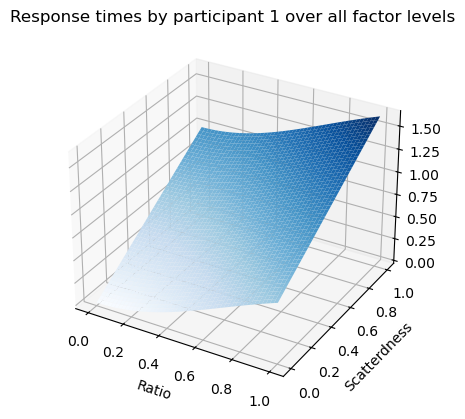

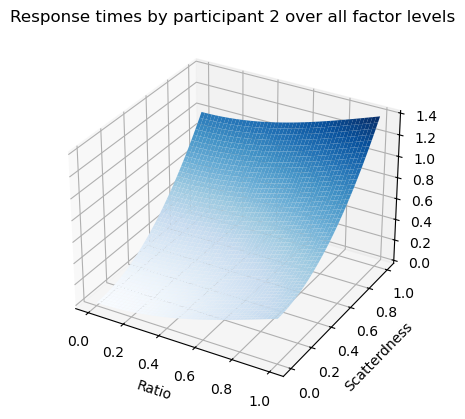

In [14]:
# replace None with your own treatment combinations
parameters_participant1 = [1, 1]
parameters_participant2 = [2, 2]

# Create two experimental units with different parameters
participant1 = experimental_unit(
    problem_solver=ground_truth,
    noise=noise,
    parameters=parameters_participant1,
    noise_level=0,
)

participant2 = experimental_unit(
    problem_solver=ground_truth,
    noise=noise,
    parameters=parameters_participant2,
    noise_level=0,
)

# define the factor levels
x = np.linspace(0,1)
y = np.linspace(0,1)
x_mesh, y_mesh = np.meshgrid(x, y)
sample_size = len(x)

# collect the observations for each participant
# add your code here (you can take the relevant code pieces from above):

# initiate the z array
z1 = np.zeros((sample_size, sample_size))

# collect the observations
for i in range(sample_size):
    z1[i, :] = participant1.step(x_mesh[i], y_mesh[i])
    
# make a surface plot to visualize the ground_truth
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_mesh, y_mesh, z1, cmap=cm.Blues)
ax.set_title('Response times by participant 1 over all factor levels')
ax.set_xlabel('Ratio')
ax.set_ylabel('Scatterdness')
plt.show()

# plot the observations for each participant in a surface plot
# add your code here (you can take the relevant code pieces from above):

# initiate the z array
z2 = np.zeros((sample_size, sample_size))

# collect the observations
for i in range(sample_size):
    z2[i, :] = participant2.step(x_mesh[i], y_mesh[i])
    
# make a surface plot to visualize the ground_truth
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_mesh, y_mesh, z2, cmap=cm.Blues)
ax.set_title('Response times by participant 2 over all factor levels')
ax.set_xlabel('Ratio')
ax.set_ylabel('Scatterdness')
plt.show()

Now add some noise and see whether you can still identify the that much difference between the observations

## Generating a dataset

Now we will take all these methods and classes, which we previously implemented to create a dataset.

This dataset will have unit-to-unit variation and also trial-to-trial variation thanks to the implemented `noise` and the `experimental_unit` class.

In this section you will learn to:
- Define the relevant dataset parameters (number units, number trials per unit)
- Define arbitrary parameter sets
- Create a collection of experimental units based on these parameter sets
- Perform runs and collect the data in the form of the collection (factors, observation)

First, we are going to define the parameters of our dataset.
This contains the extrinsic parameters over which we have full control: 
- the number of units we are going to observe
- the number of conditions each unit will be tested on
- the number of repetitions per conditions

And the intrinsic parameter for the noise level (over this parameter we usually do not have any control but which will be useful for later analyses).

In [77]:
# define the dataset parameters

# number of experimental units
n_units = 100

# number of observations per experimental unit
n_conditions = 1000

# number of repetitions per condition
n_repetitions = 10

# amount of noise which we are going to add to the data
noise_level = 0.5

Now we will define the unit parameters and the conditions

In [78]:
# create n_units arbitrary parameter sets to define n_units experimental units
# we will draw the parameters from a normal distribution around 1 but which is capped to the value range of (0, inf)
parameters = np.random.normal(1, 0.5, (n_units, 2))
parameters = np.where(parameters < 0, 0, parameters)

# create n_trials conditions which will be taken for all experimental units
# we will draw the conditions from a uniform distribution between 0 and 1
condition = np.random.uniform(0, 1, (n_conditions, 2))

After defining the parameters, we can now create instances of our experimental units

In [79]:
# create a list of experimental units
experimental_units = []

# create the experimental units
for i in range(n_units):
    experimental_units.append(
        experimental_unit(
            problem_solver=ground_truth,
            noise=noise,
            parameters=parameters[i],
            noise_level=noise_level,
        )
    )

Now we get to the part where we are creating the actual dataset.

This basically means collecting the observations for all presented the conditions to the different experimental units.

This way, we will have a 4D-Corpus of the data with the dimensions (experimental units, conditions, repetitions, unit_id+n_conditions+observation)

In [69]:
# create an array which will be the dataset
dataset = np.zeros((n_units, n_conditions, n_repetitions, 2+condition.shape[-1]))

for i in range(n_units):
    # here we collect the observations for each experimental unit
    for k in range(n_repetitions):
            # here we collect the observations for each repetition for each condition for each experimental unit
            # dataset[i, :, k] = experimental_units[i].step(conditions[:, 0], conditions[:, 1])
            observation = experimental_units[i].step(condition[:, 0], condition[:, 1])
            dataset[i, :, k, 0] += i
            dataset[i, :, k, 1:1+condition.shape[-1]] = condition
            dataset[i, :, k, -1] = observation

/tmp/ipykernel_10963/2408666003.py:17: RuntimeWarning: divide by zero encountered in divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])


Let's inspect the dataset a little bit

We will compute: 
- the mean and standard deviation (std) for each experimental unit for all conditions and repitions -> 2D arrays (n_units, n_conditions)
- the mean and std for each condition across all experimental units and repitions -> 2D arrays (n_conditions, n_conditions)

We will make:
- an errorbar plot for the unit-wise mean and std for one condition to show how the observations of one condition can differ from unit to unit 
- a 2D Hist for the condition-wise std across all participants

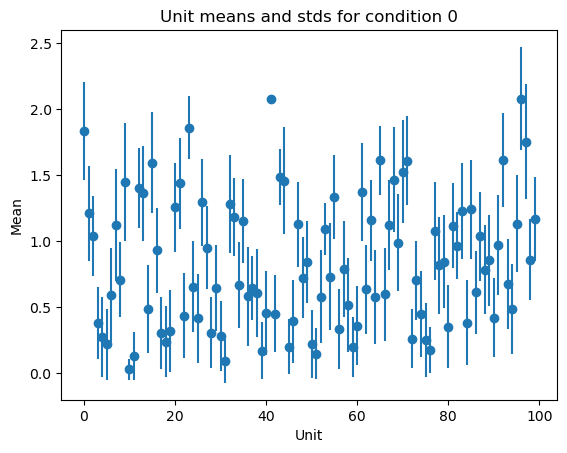

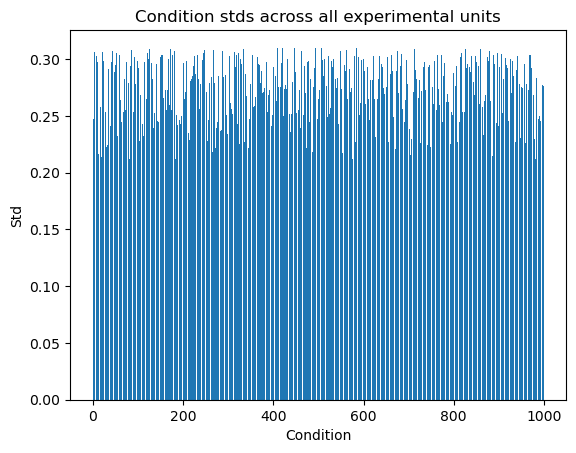

In [70]:
# set the index for the condition which will be observed
condition_index = 0

# compute the mean and std for each unit and condition
unit_mean = np.mean(dataset[:, :, :, -1], axis=1)
unit_std = np.std(dataset[:, :, :, -1], axis=1)

# compute the mean and std for each condition
condition_mean = np.mean(dataset[:, :, :, -1], axis=2)
condition_std = np.std(condition_mean, axis=0)

# plot an errorbar plot to visualize the unit means and stds for the selected condition
plt.errorbar(
    np.arange(n_units),
    unit_mean[:, condition_index],
    yerr=unit_std[:, condition_index],
    fmt='o',
)
plt.title('Unit means and stds for condition {}'.format(condition_index))
plt.xlabel('Unit')
plt.ylabel('Mean')
plt.show()

# visualize the condition stds across all experimental units over the conditions
plt.bar(
    np.arange(n_conditions),
    condition_std,
)
plt.title('Condition stds across all experimental units')
plt.xlabel('Condition')
plt.ylabel('Std')
plt.show()

How would you expect the std to change for an increased amount of trials and/or noise?

Test your assumption by changing the value for the amount of trials and/or noise an re-run the code of this section!

What did you notice?

## Model fitting

In this section we will take the previously generated dataset to fit two different models:
1. linear regression model from the `sklearn` package.
2. feed-forward neural network from the `torch` package

The linear regression model is quite easy to fit thanks to its limited amount of parameters but fits only on a group-level, i.e. it does not recover the individual differences between the participants. The applied neural network model, on the other hand, has a layer to processes the conditions AND the unit-id to fit individual behavior. Like that the neural network can process group-level information given by the whole dataset as well as indivual-level information given by single experimental units.

In this section you will learn to:
- Prepare data for model fitting
- Use data to fit a model
- Get a feeling for the significance of noise and sample size on the quality of the recovered model

### Preparing the dataset

So first we need to prepare the data for the further steps.

This will be done by:
1. Creating a 2D matrix for the generated samples of the shape `(samples, features)` with features being `(unit_id, ratio, scatteredness, observation)`
1. Shuffling along the the `samples` axis to break up any correlations other than condition-observation
1. Splitting the data into training and test data
    - Training data is used for fitting the model
    - Test data is used for evaluating the model's generalization capability and making sure it did not simply memorized the samples (i.e. overfitting)

In [71]:
# Convert the dataset to training and test data
data_recovery = dataset.reshape(-1, dataset.shape[-1])

# Shuffle the data
np.random.shuffle(data_recovery)

# Split the data into train and test data
train_ratio = 0.8  # define the amount of data which will be used for training
train_data = data_recovery[:int(len(data_recovery) * train_ratio)]  # take the first train_ratio*100% of the data for training
test_data = data_recovery[int(len(data_recovery) * train_ratio):]  # take the remaining data for testing

print(f'Number of training samples: {len(train_data)}')
print(f'Number of test samples: {len(test_data)}')

Number of training samples: 800000
Number of test samples: 200000


### Fitting a linear regression model

Next we need to implement the model fitting algorithm.

To do that, we will use a simple linear regression estimator from the sklearn package.

The `LinearRegression` estimator works only on the group level which is why we don't have to provide the `unit_id` to it. It would get only confused ;)

In [72]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(train_data[:, 1:-1], train_data[:, -1][:, None])

# Recovered parameters
recovered_a = model.coef_[0, 0]
recovered_b = model.coef_[0, 1]

# print the recovered parameters
a_true = np.round(np.mean(parameters[:, 0]), 3)
b_true = np.round(np.mean(parameters[:, 1]), 3)
print('After running experiments on {} units with {} conditions and {} repetitions per condition, we recovered the following parameters:'.format(n_units, n_conditions, n_repetitions))
print('True parameters (mean across all units): a = {}, b = {}'.format(a_true, b_true))
print('Recovered parameters: a = {}, b = {}'.format(np.round(recovered_a, 3), np.round(recovered_b, 3)))

After running experiments on 100 units with 1000 conditions and 10 repetitions per condition, we recovered the following parameters:
True parameters (mean across all units): a = 1.013, b = 0.992
Recovered parameters: a = 0.641, b = 0.84


Now we are going to test the fitted model with the test data.

We will compute the prediction accuracy with a sklearn metric and plot the model predictions over the given conditions.

Mean squared error: 0.27146011481138166
Original mean: 0.8557032189121755
Recovered mean: 0.8534531527167902


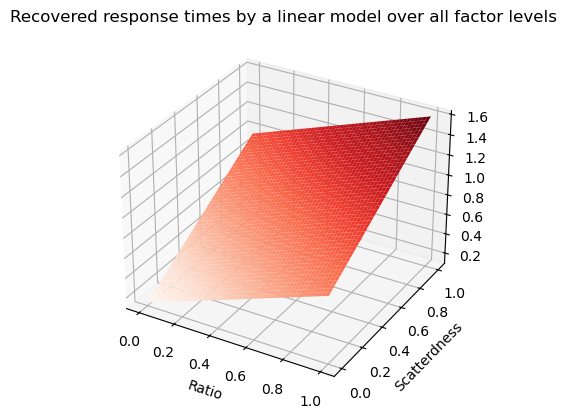

In [73]:
from sklearn.metrics import mean_squared_error

# use the fitted model to predict the test observations
observations_predicted = model.predict(test_data[:, 1:-1])

# compute the means of the two datasets
original_mean = np.mean(test_data[:, -1][:, None]) 
recovered_mean = np.mean(observations_predicted)

# compute prediciton error
prediction_accuracy = mean_squared_error(test_data[:, -1][:, None], observations_predicted)
print('Mean squared error: {}'.format(prediction_accuracy))

# compare the means
print('Original mean: {}'.format(original_mean))
print('Recovered mean: {}'.format(recovered_mean))

# plot the recovered response times over the conditions
# initiate the z array
z_recovered = np.zeros((sample_size, sample_size))

# collect the observations
for i in range(sample_size):
    condition = np.stack((x_mesh[i], y_mesh[i]), axis=-1)
    z_recovered[i, :] = model.predict(condition).reshape(-1)
    
# make a surface plot to visualize the ground_truth
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_mesh, y_mesh, z_recovered, cmap=cm.Reds)
ax.set_title('Recovered response times by a linear model over all factor levels')
ax.set_xlabel('Ratio')
ax.set_ylabel('Scatterdness')
plt.show()

How does the result on the test data look like?

A small error - compared to the average amplitude of the observation - is acceptable since it's difficult to get a perfect match. For most cases it's even impossible.

Get a feeling for the significance of noise and sample size on the quality of a fitted model and its predictive power by adjusting the number of units, conditions, repetitions and also the noise level.

### Fitting a neural network

Now we are going to train the feed-forward neural network (FFN) with the same data as the linear regression model. Unlike the linear model, you have to specify the training epochs by hand. More advanced training algorithms would specify convergence criteria, but that's not really necessary in this case due to the simplicity of data/model and training speed.

We can further wrap the FFN with the `FFNRegressor` class which inherits from `sklearn.base.BaseEstimator` to (1) make it compatible with any sklearn-based package and (2) get a pre-implemented fitting procedure which is sufficient for most cases including like ours.

In [75]:
from resources.regressors import FFN, FFNRegressor

# train a neural network model
# train_data = tensor(train_data)
model_ffn = FFNRegressor(FFN(n_units, 2), max_epochs=10, lr=0.1)
model_ffn.fit(train_data[:, 0:-1], train_data[:, -1][:, None].astype(np.float32))

# get predictions on the test data
predictions = model_ffn.predict(test_data[:, 0:-1])
loss = mean_squared_error(test_data[:, -1][:, None], predictions)
print(f"Test loss: {loss:.8f}")


epoch	train loss
1/10	0.20904016
2/10	0.20358799
3/10	0.20403999
4/10	0.20366707
5/10	0.20308368
6/10	0.20379178
7/10	0.20313990
8/10	0.20362770
9/10	0.20371684
10/10	0.20349364
Test loss: 0.20205708


How does the train and test error look like compared to the linear model? Theoretically, the network should be much better in approximating non-linear functions like our response time function. What could you change in order to make the FFN more predictive? 

You can also inspect the approximated behavior for individual experimental units in the next cell by plotting the response times. Maybe this gives you a better idea of the best possible adjustments.

Try to find the most data-efficient setup with respect to number of participants, noise, number of recorded conditions and repitions.

By setting the `unit_id` variable, you can plot different participants.

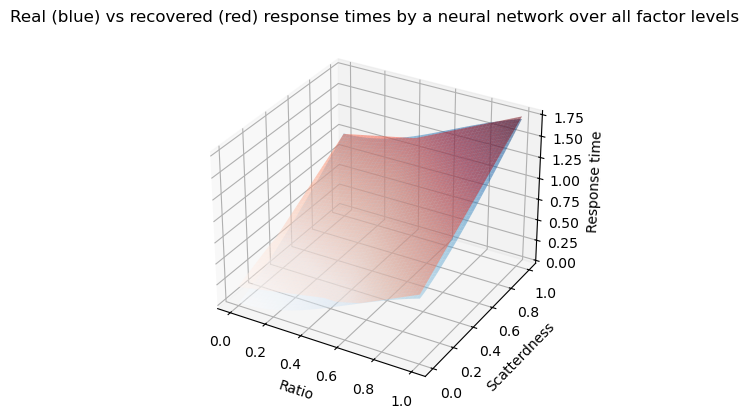

In [76]:
# plot the recovered response times over the conditions for single participants
unit_id = 0

# initiate the z array
z_recovered = np.zeros((sample_size, sample_size))
z_real = np.zeros((sample_size, sample_size))

# collect the observations
for i in range(sample_size):
    condition = np.stack((x_mesh[i], y_mesh[i]), axis=-1)
    unit_id_array=np.full((condition.shape[0], 1), unit_id)
    X = np.concatenate((unit_id_array, condition), axis=-1)
    
    z_recovered[i, :] = model_ffn.predict(X).reshape(-1)
    z_real[i, :] = experimental_units[unit_id].step(x_mesh[i], y_mesh[i], noise=False)
    
# make a surface plot to visualize the ground_truth
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_mesh, y_mesh, z_recovered, cmap=cm.Reds, alpha=0.5)
ax.plot_surface(x_mesh, y_mesh, z_real, cmap=cm.Blues, alpha=0.5)
ax.set_title('Real (blue) vs recovered (red) response times by a neural network over all factor levels')
ax.set_xlabel('Ratio')
ax.set_ylabel('Scatterdness')
ax.set_zlabel('Response time')
plt.show()

## Congratulations!

You finished the first tutorial.

Now you should have a good idea about:
- How to implement a synthetic experiment
- How to get unit-to-unit and trial-to-trial variation into your dataset
- How the sample size and noise affects the recovery of parameters